# How to Calculate Teleconnection Patterns <a class="anchor" id="top"></a>

### Notebook by Justin Bandoro

Since the [NWS Climate Prediction Center](http://www.cpc.ncep.noaa.gov/data/teledoc/telepatcalc.shtml) outlines a method to calculate teleconnection patterns they use and their associated indices, there is no open source code to see how exactly they calculate them. As part of a project looking at circulation changes I was interested in the teleconnection patterns.

In this notebook you can apply it to any gridded reanalysis product of geopotential height or sea level pressure, for any level in the atmosphere, and for both hemispheres. The files read in for this notebook are either [NCEP](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis2.surface.html) or [ERA-Interim](http://apps.ecmwf.int/datasets/) reanalyses products for geopotential height. You can easily take the code and modify to suit your needs. 

Note the files used in this notebook have already been processed and are anomaly fields.

### Output from Notebook

The notebook outputs netcdf files containing the patterns of interest over 4 seasons: DJF, MAM, JJA, SON, as well as figures of the patterns and indices.

### Input Parameters

Below are parameters to change for running the notebook, that will produced netcdf files and plots of teleconnetion patterns for different reanalyses and different levels. Note you must also select the hemisphere of interest. This notebook can be run as is by just changing the parameters below. 

In [1]:
# Specify level and dataset and hemisphere of interest
LEVEL   = 500             # 50 or 500 hPa
DATASET = 'ERA-Interim' # ERA-Interim or MERRA
HEM     = 'NH'

## Table of Contents:

1. [Load in and Prepare Data](#load)
2. [Calculate EOFs](#calceofs)
3. [Visualization of Teleconnections](#visualize)
4. [Save EOF and PC Datasets](#save)

There are a couple packages that might not be standard when running python, needed for this notebook. This notebook was built using Conda Python 3.6, and the packages that you might need to install are:

* [`xarray`](http://xarray.pydata.org/en/stable/installing.html): to load and save multidimensional datasets easily
* [`eofs`](http://ajdawson.github.io/eofs/): package written to easily calculate eofs in python
* [`cartopy`](http://scitools.org.uk/cartopy/docs/v0.15/installing.html): for mapping
* [`rpy2`](https://anaconda.org/r/rpy2): used the R wrapper for varimax rotation later in the notebook


In [2]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display
import numpy as np
import pandas as pd
import xarray as xr
import seaborn.apionly as sns
from eofs.xarray import Eof
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import warnings
warnings.filterwarnings('ignore')
import os

#-----------------------------------
# Plot Styles
#-----------------------------------
plt.style.use('seaborn-whitegrid')
matplotlib.rc('axes',edgecolor='black')
matplotlib.rc('xtick',labelsize=14)
matplotlib.rc('ytick',labelsize=14)
matplotlib.rc('axes',titlesize=16,titleweight='semibold')
matplotlib.rc('legend',fontsize=14)
matplotlib.rc('font',weight='semibold')
matplotlib.rc('axes',labelsize=14,labelweight='semibold',linewidth=2.0)
matplotlib.rcParams['xtick.major.size']=5
matplotlib.rcParams['ytick.major.size']=5
matplotlib.rcParams['xtick.major.width']=2.5
matplotlib.rcParams['ytick.major.width']=2.5
import matplotlib.path as mpath

pd.set_option('precision',1) #easy to read output

#-----------------------------------
# Reanalysis File Locations
#-----------------------------------
source_dir = 'Zg_files/'
source_file= source_dir+'OBSERVATIONS_zg_{}_1979-2012-REGRID5by5_{}hPa_Anos.nc'


## 1. Load in and Prepare Data<a class="anchor" id="load"></a>
[[back to top]](#top)


### Load in Data
Geopotential height anomalies as saved files in directory `Zg_files` for different values of `LEVEL` and `DATASET` parameters to load in.

In [3]:
# Load in Data
fname = source_file.format(DATASET,LEVEL)
if not os.path.exists(fname):
    print('WARNING: File not found, please choose LEVEL and DATASET values that exist in directory.')
    raise
    
zg_dat = xr.open_dataset(fname,decode_cf=True).squeeze(drop=True)
zg_dat

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 72, time: 408)
Coordinates:
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 -62.5 -57.5 -52.5 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Data variables:
    anos     (time, lat, lon) float64 9.01 9.51 9.032 9.282 9.304 9.349 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.2 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Tue Aug 15 12:33:53 2017: cdo sellevel,500 OBSERVATIONS_zg_...
    CDO:          Climate Data Operators version 1.6.2 (http://code.zmaw.de/p...

### Slice by latitude

Now we want to grab the hemisphere wanted, either Northern or Southern going 20 degrees and poleward.

In [4]:
LATRANGES={'NH':[20,90],'SH':[-90,-20]}

# Slice data to latitude ranges wanted
zg_slice = zg_dat.sel(lat=slice(LATRANGES[HEM][0],LATRANGES[HEM][1]))

### Standardize Anomalies

Instead of using the units of meters for height anomalies, we want to first standardize the anomalies by dividing by the standard deviation from all months. Note since we are dealing with anomalies, the mean here is already 0, so we do not have to subtract it.

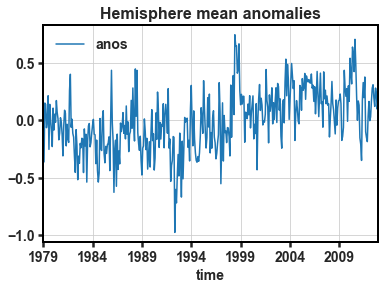

In [5]:
clim_std = zg_slice.groupby('time.month').std('time')

# Standardized zg anomalies
zg_stand = zg_slice.groupby('time.month')/clim_std

# Plot quick example from over the whole hemisphere
zg_stand.mean(dim=['lat','lon'])['anos'].to_dataframe().plot(y='anos',title='Hemisphere mean anomalies')

## 2. Calculate EOFs<a class="anchor" id="calceofs"></a>
[[back to top]](#top)

Here EOFs are calculated for each season, taking the 3 months of each year.

### Create Datasets for EOFs and PCs 

This makes it easy to later save the files as netcdf, and keeps the data well organized.

In [6]:
# Make EOF dataset to fill in with lon,lat,season and eof# top 10 
# This is the one that will be saved to project onto models
eofarr  =  np.zeros((4,10,zg_stand.dims['lat'],zg_stand.dims['lon']) )  
eof_dat = xr.Dataset( {'eofs': (['season','num','lat','lon'],eofarr )},
                      coords={'lon': zg_stand.coords['lon'],
                              'lat': zg_stand.coords['lat'],
                              'season': zg_stand['time.season'].to_series().unique(),
                              'num': np.arange(1,11),
                             }
                    )

# PC dataset for plotting the modes and their time series
pcarr = np.zeros((4,10, int(zg_stand.dims['time']/12)) );pcarr[:]=np.nan
exp_var=np.zeros((4,10))
pc_dat = xr.Dataset( {'pc': (['season','num','time'],pcarr ),
                      'fracexp': (['season','num'],exp_var )},
                     coords={'num': np.arange(1,11),
                             'season':zg_stand['time.season'].to_series().unique(),
                             'time': zg_stand['time.year'][0::12]}
                    )
display(eof_dat)
pc_dat

<xarray.Dataset>
Dimensions:  (lat: 14, lon: 72, num: 10, season: 4)
Coordinates:
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
  * lat      (lat) float64 22.5 27.5 32.5 37.5 42.5 47.5 52.5 57.5 62.5 67.5 ...
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * num      (num) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    eofs     (season, num, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

<xarray.Dataset>
Dimensions:  (num: 10, season: 4, time: 34)
Coordinates:
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  * num      (num) int64 1 2 3 4 5 6 7 8 9 10
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * time     (time) int64 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 ...
Data variables:
    pc       (season, num, time) float64 nan nan nan nan nan nan nan nan nan ...
    fracexp  (season, num) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

### Grab Months for Seasons

The Function below selects months used to compute the EOFs, for DJF, it excludes the month that is not directly sequential with the rest. 

In [7]:
def is_season(season,months):
    """Function that selects 3 month season,
    """
    if season == 'DJF': month0=12;month1=1;month2=2
    elif season=='MAM': month0=3;month1=4;month2=5
    elif season=='JJA': month0=6;month1=7;month2=8
    elif season=='SON': month0=9;month1=10;month2=11
    
    indices=(months == month0) | (months == month1) | (months == month2)
    if season=='DJF':  indices[-1]= False
    return indices

### Varimax Rotation of EOFs

Below is a function that rotates EOFs to reduce the variances of the projection of the data onto the rotated basis, thereby putting the basis closer to the actual data and increasing interpretability. Thus for our purposes there will be more regional patterns and less hemispheric scale patterns.

Note below assumes that the eofs to be rotated have already been scaled by the square root of its respective eigenvalues.

In [8]:
def rot_eofs(pcs,eofs,normalize=True):
    """ Performs varimax rotation, and then projects the rotated eofs
        onto the anomaly field to retrieve new principal components
    """
    from rpy2 import robjects
    import rpy2.robjects.numpy2ri
    shape = eofs.shape
    npcs  = pcs.shape[-1]
    
    rpy2.robjects.numpy2ri.activate()
    r = robjects.r
    
    # Multiply by eig values
    eofreshape = eofs.reshape((npcs,np.prod(shape[1:])))
    varimax = r.varimax(eofreshape.T,normalize=normalize)#eofs.reshape((npcs,np.prod(shape[1:]))).T,normalize=normalize)

    rpy2.robjects.numpy2ri.deactivate()

    roteofs = np.array(varimax.rx2(1)).T.reshape(shape)
    rotpcs = pcs
    return roteofs,rotpcs

### Season Mean for PCs

Another function that computes the PC time series as a mean of the season months, input is an xarray dataarray. It also shifts the years for DJF, as here we define the year to be that of the January year value.

In [9]:
## Season mean
def season_mean(xarr,season):
    years  = xarr['time.year'].values
    months = xarr['time.month'].values
    if season !='DJF':
        smean = xarr.groupby('time.year').mean('time').values.T
    else:
        # Shift december in years up one
        years[(months==12)] = years[(months==12)] + 1
        xarr['time.year'].values[:] = years
        smean = xarr.groupby('time.year').mean('time').values.T
    return smean

### EOF Calculation and Rotation

This is the heavy lifting of the code:

1. Weights are the square root of the cosine of latitude
2. Loops over all seasons
3. For each season calculates eofs, scaling them by the square root of the eigenvalues. Then rotates the eofs using varimax rotation. Then projects the eofs back onto the original field data to retrieve the pcs associated with the rotated eofs.
4. Puts all of the 10 eofs and 4 season data into the datasets.

In [10]:
## Weight by cosine
coslat = np.cos(np.deg2rad(zg_stand.coords['lat'].values)).clip(0., 1.)
wgts   = np.sqrt(coslat)[..., np.newaxis]

# Loop over months
for i,s in enumerate( ['DJF','MAM','JJA','SON']):
    
    # Get month data
    zg_seas =  zg_stand.sel(time=is_season(s,zg_stand['time.month']))
 
    # Calculate EOFs - scaling by multiply square root of eigs for rotation
    solver  = Eof(zg_seas.to_array().squeeze(), weights=wgts)
    eofs    = solver.eofs(eofscaling=2,neofs=10)#eofsAsCovariance(neofs=10)
    pcs     = solver.pcs(npcs=10, pcscaling=1)
    fracexp = solver.varianceFraction(neigs=10)
    
    # Rotate varimax
    roteofs,_   = rot_eofs(pcs.values,eofs.values,normalize=True)
    
    # New PCs - scale by square root of eigenvalues
    solver.eofs()[0:10,...] = roteofs
    rotpcs = solver.projectField(zg_seas.to_array().squeeze(),neofs=10,eofscaling=1)
    
    # Fill in arrays
    eof_dat['eofs'][i,:,:,:] = roteofs
    pcs.values[:,:] = rotpcs.values
    # Calculate seasonal mean of PCs
    smean = season_mean(pcs[:,:],s)
    pc_dat['pc'][i,...] = smean
    pc_dat['fracexp'][i,:] = fracexp.values


## 3. Visualization of Teleconnections<a class="anchor" id="visualize"></a>
[[back to top]](#top)

### RREOFs
Below we plot all of the calculated REOFs in one figure. Use Cartopy for the mapping transformation for either NH or SH polar stereographic projections. 

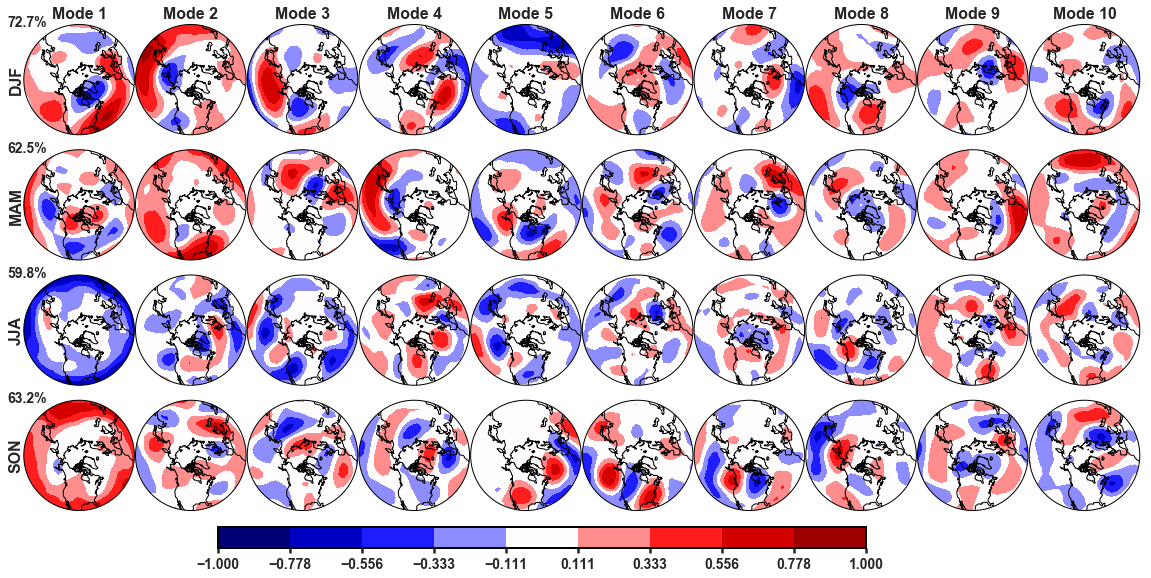

In [11]:
# Contour levels
clevs = np.linspace(-1,1,10)

# Which hemisphere to use for projection
if HEM=='SH':
    extent=[-180, 180, -90,-23];cl=-100;tsl=-70
    proj = ccrs.SouthPolarStereo(central_longitude=cl)
elif HEM=='NH':
    extent=[-180,180, 23,90];cl=-100;tsl=70
    proj = ccrs.NorthPolarStereo(central_longitude=cl)

# Create figure
fig1,axes = plt.subplots(4,10,figsize=[20,10],subplot_kw={'projection': proj} )

[ax.coastlines() for ax in axes.ravel() ]
[ax.set_extent(extent,crs=ccrs.PlateCarree()) for ax in axes.ravel()]

# Circle Boundary in axes
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
[ax.set_boundary(circle, transform=ax.transAxes) for ax in axes.ravel()]
    
# Loop through and plot REOFs
for i,s in enumerate(['DJF','MAM','JJA','SON']):
    for e in range(1,11):
        ax = axes[i,e-1]
        if e==1:
            ax.text(0, 0.5, str(s) ,fontsize=16,horizontalalignment='right', verticalalignment='center',rotation='vertical',transform=ax.transAxes)
            exp_var = pc_dat['fracexp'][i,:].values*100
            ax.text(-0.15,0.98,'{:.1f}%'.format(np.sum(exp_var)),transform=ax.transAxes,fontsize=14)

        eof_e =eof_dat.sel(season=s,num=e)['eofs']
        cyclic_data, cyclic_lons = add_cyclic_point(eof_e.values, coord=zg_stand['lon'][:] )
        cs = ax.contourf(cyclic_lons, zg_stand['lat'][:], cyclic_data, cmap=plt.cm.seismic, 
            transform=ccrs.PlateCarree(),levels=clevs)
        if i==0: ax.set_title('Mode {}'.format(e),fontsize=16,weight='semibold')
        
fig1.subplots_adjust(bottom=0.2,hspace=0.1,wspace=0.01)
cbar_ax = fig1.add_axes([0.26, 0.15, 0.45, 0.03])
fig1.colorbar(cs, cax=cbar_ax,orientation='horizontal')    

### PCs

Below we plot the associated PC time series with the figure above.

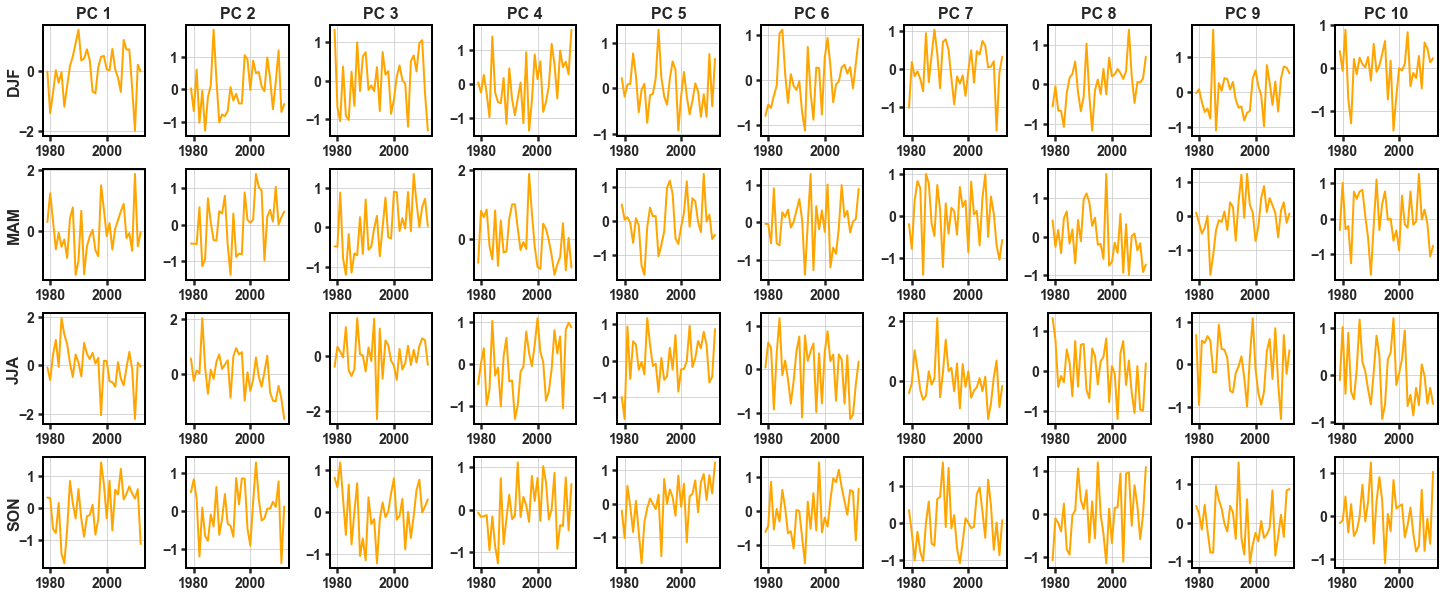

In [12]:
fig2,axes = plt.subplots(4,10,figsize=[25,10] )
# Loop through and plot PCs
for i,s in enumerate(['DJF','MAM','JJA','SON']):
    for e in range(1,11):
        ax = axes[i,e-1]
        if e==1:
            ax.text(-0.2, 0.5, str(s) ,fontsize=16,horizontalalignment='right', verticalalignment='center',rotation='vertical',transform=ax.transAxes)
        pc_e =pc_dat.sel(season=s,num=e)
        ax.plot(pc_e['time'].values,pc_e['pc'].values,linewidth=2.0,color='orange')
        
        if i==0: ax.set_title('PC {}'.format(e),fontsize=16,weight='semibold')

fig2.subplots_adjust(hspace=0.3,wspace=0.4)

### Save Figures to File

Saves them into the `Plot` directory

In [13]:
import matplotlib.backends.backend_pdf

savename = 'Plots/{}_{}_{}hPa_Teleconnections.pdf'.format(DATASET,HEM,LEVEL)
pdf = matplotlib.backends.backend_pdf.PdfPages(savename)
for fig in [fig1,fig2]:
    pdf.savefig( fig )
pdf.close()

## 4. Save EOF and PC Datasets<a class="anchor" id="save"></a>
[[back to top]](#top)

Using xarray to save our datasets into `OutFiles` directory.

In [14]:
eofsave = 'OutFiles/{}_{}_{}hPa_RREOFs.nc'.format(DATASET,HEM,LEVEL)
pcsave  = 'OutFiles/{}_{}_{}hPa_PCs.nc'.format(DATASET,HEM,LEVEL)

eof_dat.to_netcdf(eofsave)
pc_dat.to_netcdf(pcsave)

## License
The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/). 
